<a href="https://colab.research.google.com/github/indweller/gamengen-wm/blob/main/Evaluation_(Metrics)_for_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/aravinds-kannappan/MarioGPT.git

Cloning into 'MarioGPT'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 171 (delta 65), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (171/171), 528.90 KiB | 12.90 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [2]:
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
    "torch", "torchvision", "diffusers", "transformers", "accelerate",
    "datasets", "huggingface_hub", "safetensors",
    "opencv-python-headless", "scipy", "lpips", "pillow", "tqdm"
])



0

In [3]:
sys.path.insert(0, '/content/MarioGPT/GameNGen')
import numpy as np
import torch
from pathlib import Path
from typing import List, Optional
import cv2
import os
import random
from PIL import Image
from tqdm import tqdm
from diffusers.image_processor import VaeImageProcessor

from mario_eval_metrics import MarioEvaluator
from mario_image_quality import MarioImageQualityEvaluator
from adversarial_distribution_eval import AdversarialDistributionEvaluator
from config_sd import BUFFER_SIZE, CFG_GUIDANCE_SCALE, TRAINING_DATASET_DICT, DEFAULT_NUM_INFERENCE_STEPS
from dataset import EpisodeDataset, collate_fn, get_single_batch
from model import load_model
from run_inference import (
    decode_and_postprocess,
    encode_conditioning_frames,
    next_latent,
    run_inference_img_conditioning_with_params,
)

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [4]:
class MarioGenerationPipeline:
    """Generate frames using the existing model and inference code"""

    def __init__(self, model_folder: str, device: str = None):
        self.model_folder = model_folder
        self.device = device or torch.device(
            "cuda" if torch.cuda.is_available()
            else "mps" if torch.backends.mps.is_available()
            else "cpu"
        )
        self.unet = None
        self.vae = None
        self.action_embedding = None
        self.noise_scheduler = None
        self.tokenizer = None
        self.text_encoder = None

    def load_model(self):
        """Load model using existing model.py"""
        print(f"Loading model from {self.model_folder}...")
        self.unet, self.vae, self.action_embedding, self.noise_scheduler, self.tokenizer, self.text_encoder = load_model(
            self.model_folder, device=self.device
        )
        self.vae_scale_factor = 2 ** (len(self.vae.config.block_out_channels) - 1)
        self.image_processor = VaeImageProcessor(vae_scale_factor=self.vae_scale_factor)
        print("Model loaded!")
        return self

    def generate_single_frame(self, batch: dict) -> np.ndarray:
        """Generate single frame using run_inference logic"""
        img = run_inference_img_conditioning_with_params(
            self.unet,
            self.vae,
            self.noise_scheduler,
            self.action_embedding,
            self.tokenizer,
            self.text_encoder,
            batch,
            device=self.device,
            skip_action_conditioning=False,
            do_classifier_free_guidance=False,
            guidance_scale=CFG_GUIDANCE_SCALE,
            num_inference_steps=DEFAULT_NUM_INFERENCE_STEPS,
        )
        return np.array(img)

    def generate_rollout(self, actions: list, initial_frame_context: torch.Tensor,
                         initial_action_context: torch.Tensor) -> List[np.ndarray]:
        """Generate rollout using run_autoregressive logic"""
        all_images = []
        current_actions = initial_action_context
        context_latents = initial_frame_context

        for i in tqdm(range(len(actions)), desc="Generating rollout"):
            target_latents = next_latent(
                unet=self.unet,
                vae=self.vae,
                noise_scheduler=self.noise_scheduler,
                action_embedding=self.action_embedding,
                context_latents=context_latents.unsqueeze(0),
                device=self.device,
                skip_action_conditioning=False,
                do_classifier_free_guidance=False,
                guidance_scale=CFG_GUIDANCE_SCALE,
                num_inference_steps=DEFAULT_NUM_INFERENCE_STEPS,
                actions=current_actions.unsqueeze(0),
            )

            current_actions = torch.cat([
                current_actions[(-BUFFER_SIZE + 1):],
                torch.tensor([actions[i]]).to(self.device),
            ])
            context_latents = torch.cat([context_latents[(-BUFFER_SIZE + 1):], target_latents], dim=0)

            img = decode_and_postprocess(
                vae=self.vae, image_processor=self.image_processor, latents=target_latents
            )
            all_images.append(np.array(img))

        return all_images

    def generate_batch_from_dataset(self, n_samples: int, dataset_name: str = None) -> np.ndarray:
        """Generate multiple frames from dataset"""
        dataset_name = dataset_name or TRAINING_DATASET_DICT["small"]
        dataset = EpisodeDataset(dataset_name)

        generated_frames = []
        indices = random.sample(range(BUFFER_SIZE, len(dataset)), min(n_samples, len(dataset) - BUFFER_SIZE))

        for idx in tqdm(indices, desc="Generating frames"):
            batch = collate_fn([dataset[idx]])
            img = self.generate_single_frame(batch)
            generated_frames.append(img)

        return np.stack(generated_frames)

    def get_original_frames_from_dataset(self, n_samples: int, dataset_name: str = None) -> np.ndarray:
        """Get original frames from dataset for comparison"""
        dataset_name = dataset_name or TRAINING_DATASET_DICT["small"]
        dataset = EpisodeDataset(dataset_name)

        original_frames = []
        indices = random.sample(range(BUFFER_SIZE, len(dataset)), min(n_samples, len(dataset) - BUFFER_SIZE))

        for idx in indices:
            batch = collate_fn([dataset[idx]])
            # Get target frame (last frame in buffer)
            img_tensor = batch["pixel_values"][0, -1]  # Shape: (3, H, W)
            # Denormalize: from [-1, 1] to [0, 255]
            img = ((img_tensor.permute(1, 2, 0).numpy() + 1) * 127.5).astype(np.uint8)
            original_frames.append(img)

        return np.stack(original_frames)


def run_full_evaluation(generated: np.ndarray, original: np.ndarray):
    """Run all three evaluation categories"""

    print("\n" + "=" * 60)
    print("MARIO DIFFUSION MODEL EVALUATION")
    print("=" * 60)

    # Resize if needed
    if generated.shape[1:3] != original.shape[1:3]:
        print(f"Resizing generated {generated.shape} to match original {original.shape}")
        resized = []
        for frame in generated:
            r = cv2.resize(frame, (original.shape[2], original.shape[1]))
            resized.append(r)
        generated = np.stack(resized)

    # 1. Visual Fidelity
    print("\n[1/3] Visual Fidelity Metrics...")
    eval1 = MarioEvaluator()
    visual_results = eval1.evaluate_visual_fidelity(original, generated)
    print(f"  PSNR: {visual_results['psnr_mean']:.2f} dB")
    print(f"  LPIPS: {visual_results.get('lpips_mean', 'N/A')}")

    # 2. Image Quality
    print("\n[2/3] Image Quality Metrics...")
    eval2 = MarioImageQualityEvaluator()
    quality_results = eval2.evaluate_batch(original, generated)
    print(f"  SSIM: {quality_results['ssim_mean']:.4f}")
    print(f"  Histogram Similarity: {quality_results['histogram_similarity_mean']:.4f}")
    print(f"  Edge Similarity: {quality_results['edge_similarity_mean']:.4f}")

    # 3. Distribution Shift
    print("\n[3/3] Distribution Shift Metrics...")
    eval3 = AdversarialDistributionEvaluator()
    dist_results = eval3.evaluate_distribution_shift(original, generated)
    print(f"  FID: {dist_results['fid']:.2f}")
    print(f"  MMD: {dist_results['mmd']:.6f}")
    print(f"  KL Divergence: {dist_results['kl_divergence_mean']:.4f}")
    print(f"  Wasserstein: {dist_results['wasserstein_mean']:.4f}")

    all_results = {
        "visual_fidelity": visual_results,
        "image_quality": quality_results,
        "distribution": dist_results
    }

    return all_results

# ===== CONFIGURATION - EDIT THESE =====
MODEL_FOLDER = "Flaaaande/mario-sd"  # Change to your model path
N_SAMPLES = 1000
DATASET = None  # Uses default dataset

# Initialize pipeline
pipeline = MarioGenerationPipeline(model_folder=MODEL_FOLDER)
pipeline.load_model()

# Generate frames
print(f"\nGenerating {N_SAMPLES} frames...")
generated = pipeline.generate_batch_from_dataset(N_SAMPLES, DATASET)
print(f"Generated shape: {generated.shape}")

# Get original frames
print(f"Loading {N_SAMPLES} original frames...")
original = pipeline.get_original_frames_from_dataset(N_SAMPLES, DATASET)
print(f"Original shape: {original.shape}")

# Save samples
Path("generated_samples").mkdir(exist_ok=True)
for i, frame in enumerate(generated[:5]):
    cv2.imwrite(f"generated_samples/gen_{i}.png", cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
print("Saved sample frames to generated_samples/")

# Run evaluation
results = run_full_evaluation(generated, original)

print("\n" + "=" * 60)
print("EVALUATION COMPLETE")
print("=" * 60)


Loading model from Flaaaande/mario-sd...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


embedding_info.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

action_embedding_model.safetensors:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

Model loaded!

Generating 1000 frames...


README.md:   0%|          | 0.00/483 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

data/train-00000-of-00022.parquet:   0%|          | 0.00/450M [00:00<?, ?B/s]

data/train-00001-of-00022.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

data/train-00002-of-00022.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

data/train-00003-of-00022.parquet:   0%|          | 0.00/461M [00:00<?, ?B/s]

data/train-00004-of-00022.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

data/train-00005-of-00022.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

data/train-00006-of-00022.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

data/train-00007-of-00022.parquet:   0%|          | 0.00/455M [00:00<?, ?B/s]

data/train-00008-of-00022.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

data/train-00009-of-00022.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/train-00010-of-00022.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

data/train-00011-of-00022.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

data/train-00012-of-00022.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

data/train-00013-of-00022.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

data/train-00014-of-00022.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

data/train-00015-of-00022.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

data/train-00016-of-00022.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

data/train-00017-of-00022.parquet:   0%|          | 0.00/479M [00:00<?, ?B/s]

data/train-00018-of-00022.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

data/train-00019-of-00022.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

data/train-00020-of-00022.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

data/train-00021-of-00022.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/737134 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/19 [00:00<?, ?it/s]

Generating frames: 100%|██████████| 1000/1000 [12:22<00:00,  1.35it/s]


Generated shape: (1000, 240, 240, 3)
Loading 1000 original frames...


Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/19 [00:00<?, ?it/s]

Original shape: (1000, 240, 240, 3)
Saved sample frames to generated_samples/

MARIO DIFFUSION MODEL EVALUATION

[1/3] Visual Fidelity Metrics...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 196MB/s]


  PSNR: 8.03 dB
  LPIPS: 0.6140329305082559

[2/3] Image Quality Metrics...
  SSIM: 0.3208
  Histogram Similarity: 0.2200
  Edge Similarity: 0.1208

[3/3] Distribution Shift Metrics...
  FID: 1047475.96
  MMD: 0.002011
  KL Divergence: 2.3352
  Wasserstein: 49.6985

EVALUATION COMPLETE


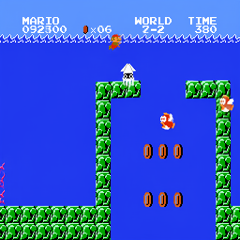

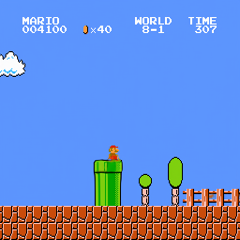

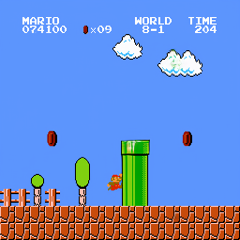

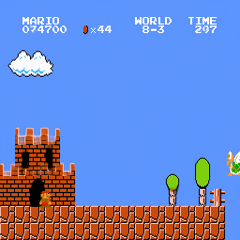

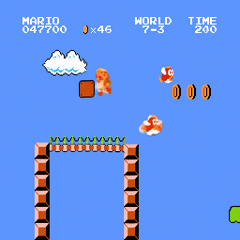

In [5]:
from IPython.display import Image, display

for i in range(5):
    display(Image(filename=f"generated_samples/gen_{i}.png"))

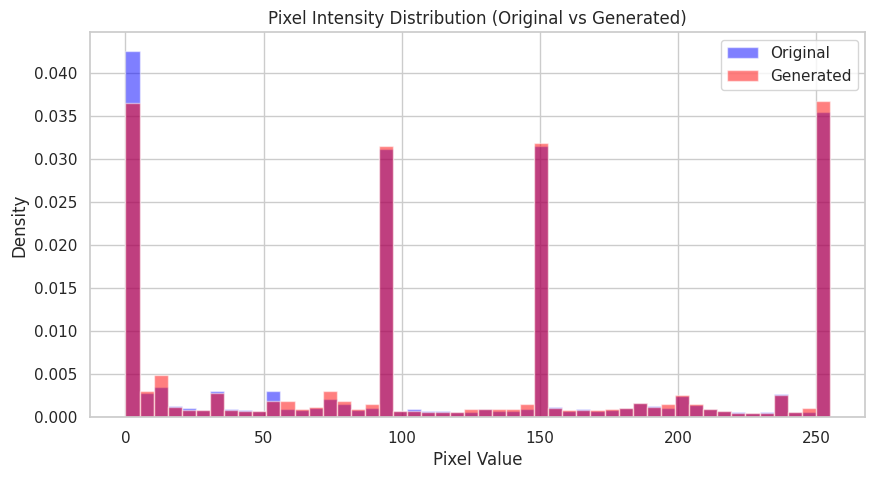

Computing per-sample PSNR for distribution plots...


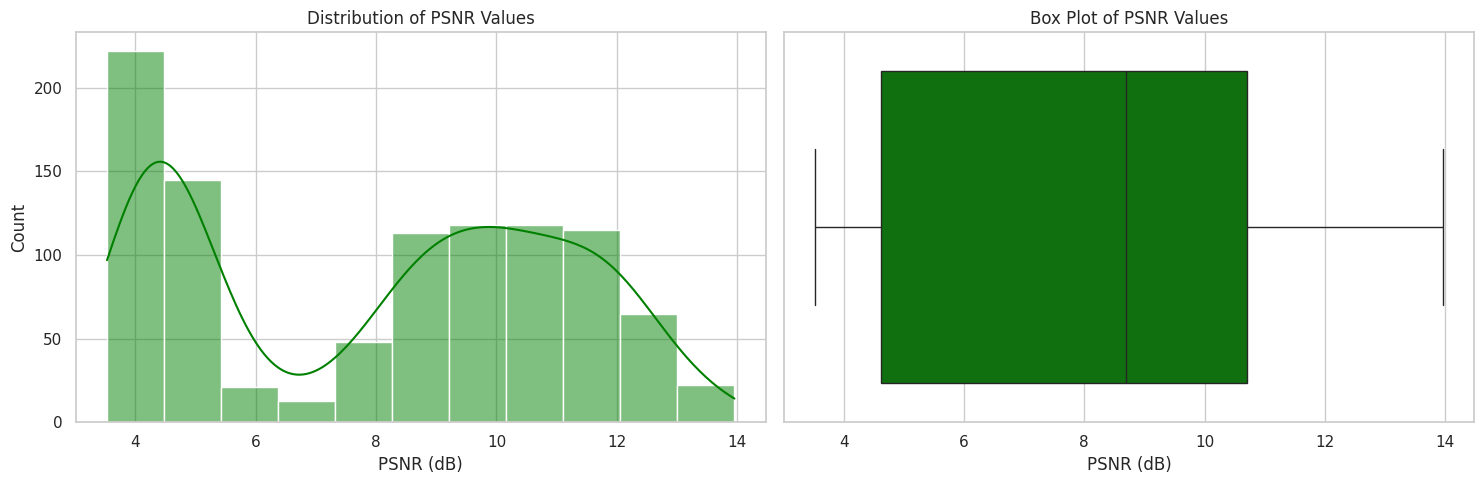

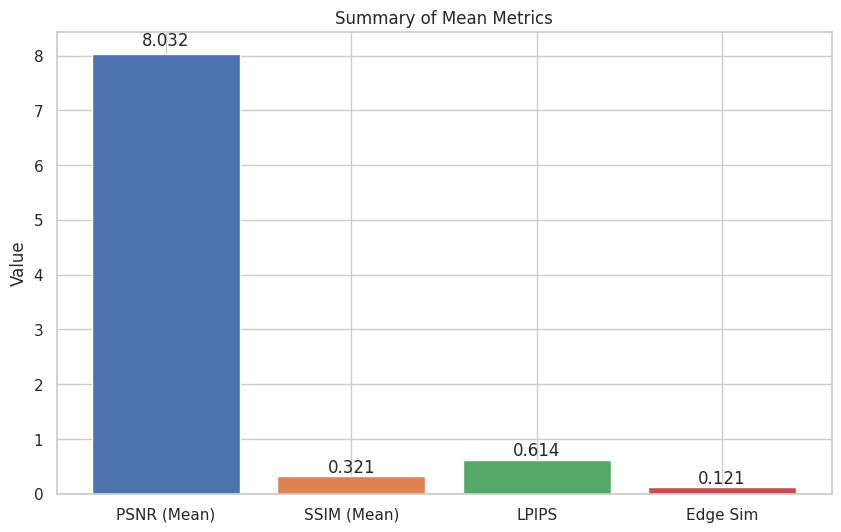

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_theme(style="whitegrid")

# 1. Pixel Intensity Histogram
plt.figure(figsize=(10, 5))
plt.hist(original.flatten(), bins=50, alpha=0.5, label='Original', color='blue', density=True)
plt.hist(generated.flatten(), bins=50, alpha=0.5, label='Generated', color='red', density=True)
plt.title('Pixel Intensity Distribution (Original vs Generated)')
plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# 2. Compute per-sample PSNR for distribution plots
def compute_psnr(img1, img2):
    mse = np.mean((img1.astype(float) - img2.astype(float)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(255.0 / np.sqrt(mse))

print("Computing per-sample PSNR for distribution plots...")
psnr_values = [compute_psnr(original[i], generated[i]) for i in range(len(original))]

# 3. PSNR Distribution (Histogram + Box Plot)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
sns.histplot(psnr_values, kde=True, ax=axes[0], color='green')
axes[0].set_title('Distribution of PSNR Values')
axes[0].set_xlabel('PSNR (dB)')

# Box Plot
sns.boxplot(x=psnr_values, ax=axes[1], color='green')
axes[1].set_title('Box Plot of PSNR Values')
axes[1].set_xlabel('PSNR (dB)')

plt.tight_layout()
plt.show()

# 4. Bar chart of summary metrics from 'results'
metrics_summary = {
    'PSNR (Mean)': results['visual_fidelity']['psnr_mean'],
    'SSIM (Mean)': results['image_quality']['ssim_mean'],
    'LPIPS': results['visual_fidelity'].get('lpips_mean', 0),
    'Edge Sim': results['image_quality'].get('edge_similarity_mean', 0)
}

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_summary.keys(), metrics_summary.values(), color=['#4C72B0', '#DD8452', '#55A868', '#C44E52'])
plt.title('Summary of Mean Metrics')
plt.ylabel('Value')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (height*0.01),
             f'{height:.3f}',
             ha='center', va='bottom')

plt.show()

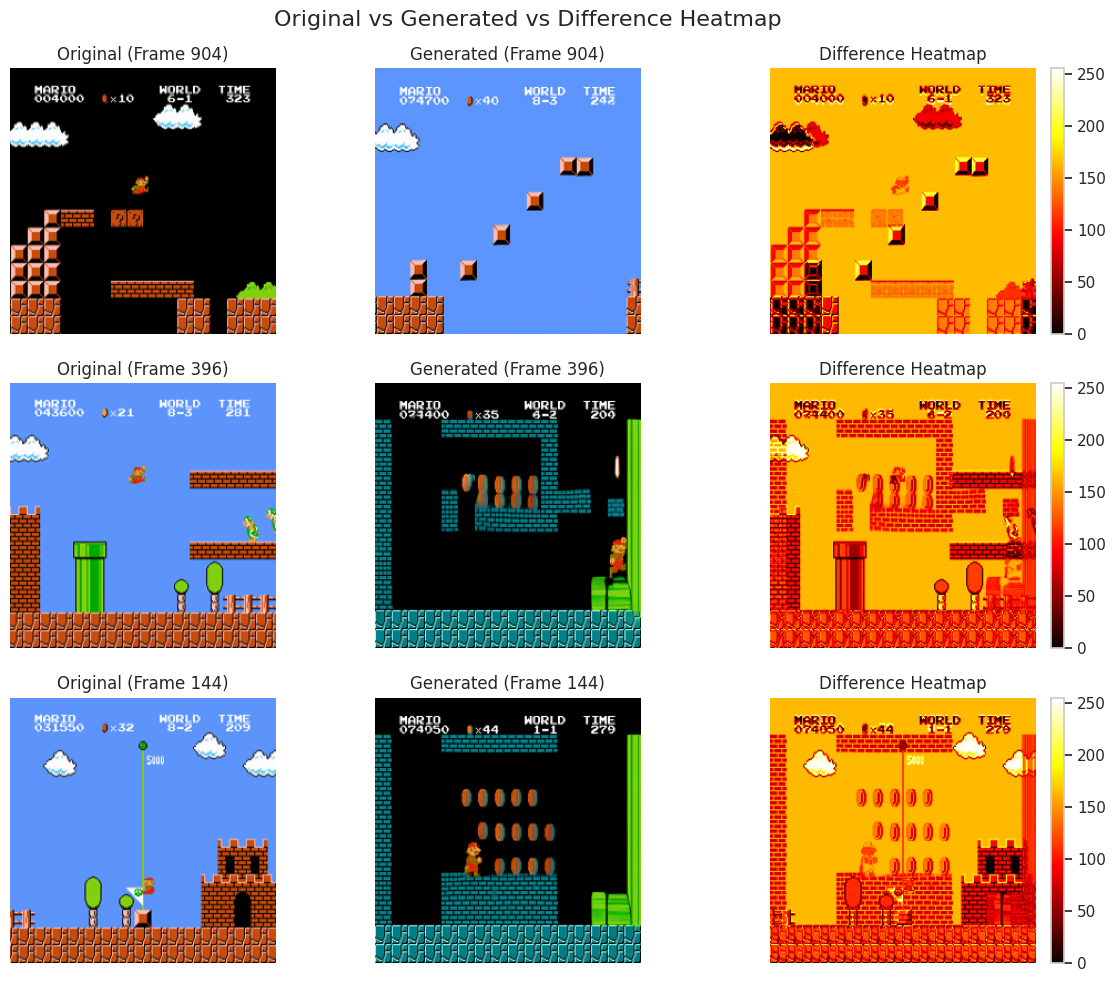

In [7]:
from skimage.metrics import structural_similarity as ssim
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# --- Visual 1: Difference Heatmaps ---
# Select 3 random indices to visualize
indices = random.sample(range(len(generated)), 3)

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
plt.suptitle("Original vs Generated vs Difference Heatmap", fontsize=16)

for i, idx in enumerate(indices):
    # Original Frame
    axes[i, 0].imshow(original[idx])
    axes[i, 0].set_title(f"Original (Frame {idx})")
    axes[i, 0].axis('off')

    # Generated Frame
    axes[i, 1].imshow(generated[idx])
    axes[i, 1].set_title(f"Generated (Frame {idx})")
    axes[i, 1].axis('off')

    # Difference Map
    # Calculate absolute difference and mean across channels for intensity
    diff = np.abs(original[idx].astype(np.float32) - generated[idx].astype(np.float32))
    diff_intensity = np.mean(diff, axis=2)

    im = axes[i, 2].imshow(diff_intensity, cmap='hot', vmin=0, vmax=255)
    axes[i, 2].set_title(f"Difference Heatmap")
    axes[i, 2].axis('off')

    # Add colorbar for the last plot in the row
    fig.colorbar(im, ax=axes[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

Computing per-sample SSIM values (this may take a few seconds)...


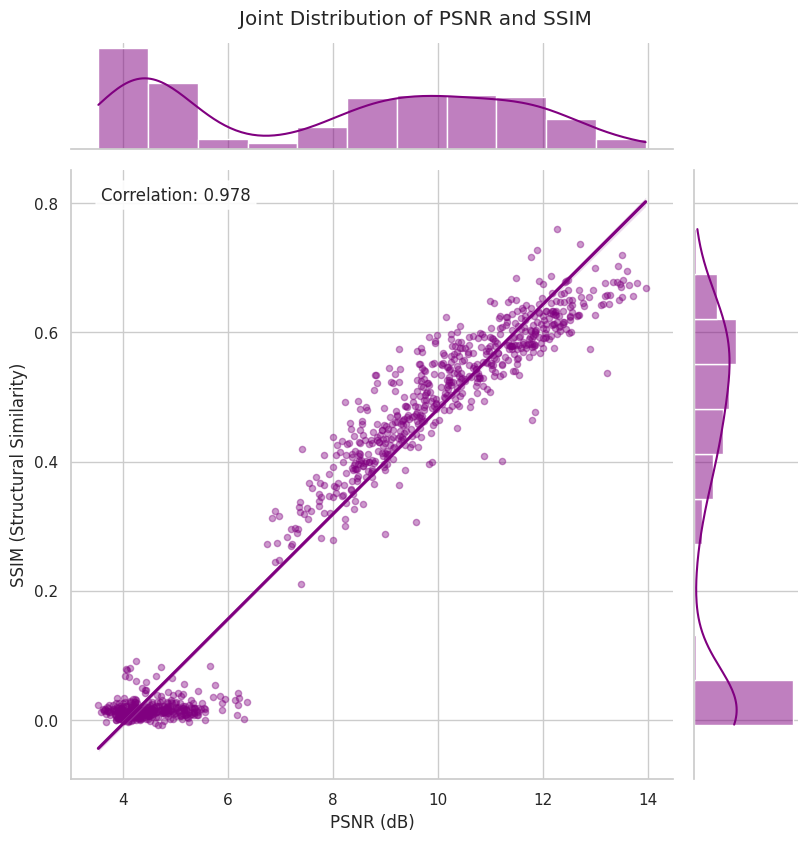

In [9]:
# --- Visual 2: PSNR vs SSIM Correlation ---
print("Computing per-sample SSIM values (this may take a few seconds)...")

ssim_values = []
for i in range(len(generated)):
    # channel_axis=2 tells ssim that the last dimension is color channels
    score = ssim(original[i], generated[i], channel_axis=2, data_range=255)
    ssim_values.append(score)

# Create a Joint Plot (Scatter + Histograms)
g = sns.jointplot(x=psnr_values, y=ssim_values, kind="reg", color="purple", height=8,
                  scatter_kws={'alpha': 0.4, 's': 20})

g.fig.suptitle('Joint Distribution of PSNR and SSIM', y=1.02)
g.set_axis_labels('PSNR (dB)', 'SSIM (Structural Similarity)', fontsize=12)

# Add correlation text
corr = np.corrcoef(psnr_values, ssim_values)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=g.ax_joint.transAxes,
         fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.show()